<a href="https://colab.research.google.com/github/tifat58/PET-2020/blob/master/pet_attack1_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import random

plt.ion()   # interactive mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
device

device(type='cpu')

In [7]:
def get_target_label_idx(labels, targets, shots=5, test=False):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    final_list = []
    #Both if and else operations seem to be the same, what would be the purpose of this?
    for t in targets:
        if test:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
        else:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
    
    return final_list


# function to convert labels [5,6,7,8,9] to [0,1,2,3,4]
# Do we need this? If yes, what would be the purpose of this?
def convert_label(x):

    if x >= 5:
        return x-5
    else:
        return x

In [27]:
#Might help cleaning the code: Subset has already been imported once.
from torch.utils.data import Subset
from PIL import Image
from torchvision.datasets import MNIST, CIFAR10

#Might help cleaning the code: transforms has already been imported once.
import torchvision.transforms as transforms

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class CIFAR10_Dataset(Dataset):

    def __init__(self, root: str, normal_class=[0,1,2,3,4,5,6,7,8,9], shots=5):
        super().__init__()

        self.root = root
#         self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = tuple(normal_class)
#         self.outlier_classes = list(range(0, 10))
#         self.outlier_classes = [item for item in self.outlier_classes if item not in self.normal_classes]
# #         self.outlier_classes.remove(normal_class)
#         print("classes: ", self.normal_classes)
#         # MNIST preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        

        # target_transform = transforms.Lambda(lambda x: int(x in self.normal_classes))
        
        target_transform = transforms.Lambda(lambda x: convert_label(x))

        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_set = MyCIFAR10(root=self.root, train=True, download=True,
                            transform=transform)
        
        train_index = get_target_label_idx(train_set.targets, self.normal_classes, shots=shots)
        
        # shadow_idx_normal = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.normal_classes, shots=shots)
        print(type(train_index))
        random.shuffle(train_index)
        print(train_index[0:500])
        train_index_half_len = int(len(train_index)/2)
        shadow_set = Subset(train_set, train_index[0:train_index_half_len])
        target_set = Subset(train_set, train_index[train_index_half_len:])

        shadow_half_len = int(len(shadow_set)/2)
        print("shadow half len: ", shadow_half_len)
        self.shadow_train = Subset(shadow_set, list(range(0, shadow_half_len)))
        self.shadow_test = Subset (shadow_set, list(range(shadow_half_len, len(shadow_set))))

        # self.target_classes = tuple([5,6,7,8,9])
        # target_idx_normal = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.target_classes, shots=shots)
        # random.shuffle(target_idx_normal)
        # target_set = Subset(train_set, target_idx_normal)
        target_half_len = int(len(target_set)/2)
        print("Target half len: ", target_half_len)
        self.target_train = Subset(target_set, list(range(0, target_half_len)))
        self.target_unknown = Subset(target_set, list(range(target_half_len, len(target_set))))

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


        # test_set = MyMNIST(root=self.root, train=False, download=True,
        #                         transform=transform)

In [ ]:
class MyMNIST(MNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed

In [23]:
class MyCIFAR10(CIFAR10):
    """Torchvision CIFAR10 class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyCIFAR10, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the CIFAR10 class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.data[index], self.targets[index]
        else:
            img, target = self.test_data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # print(type(img))
        img = Image.fromarray(img)


        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed

In [30]:
dataset = CIFAR10_Dataset(root='data/', shots=5)
shadow_train_loader = DataLoader(dataset.shadow_train, batch_size=64, shuffle=True, num_workers=0)
shadow_test_loader = DataLoader(dataset.shadow_test, batch_size=64, shuffle=True, num_workers=0)



Files already downloaded and verified
<class 'list'>
[15253, 43654, 48025, 47842, 18558, 11807, 291, 10575, 35287, 17004, 26152, 8827, 9974, 36613, 3595, 42026, 12664, 47236, 27065, 19727, 35592, 29240, 42905, 14785, 9670, 30593, 5875, 16301, 17375, 13449, 7082, 35938, 28084, 34448, 15587, 23199, 36481, 46416, 4552, 35936, 19862, 43054, 32616, 38490, 48043, 36086, 26310, 19802, 23072, 32704, 48974, 25538, 8395, 5416, 25044, 42019, 22741, 5484, 42044, 9887, 1236, 30214, 957, 46644, 38510, 48964, 38995, 19464, 25229, 25815, 45904, 37585, 4789, 33668, 19742, 14236, 8624, 7175, 44410, 29444, 27738, 9123, 4022, 24191, 15606, 4205, 46124, 43129, 3310, 47415, 32857, 26375, 31925, 4269, 48546, 40309, 36988, 48815, 37409, 4842, 44638, 9041, 15646, 7856, 18500, 47157, 12258, 33098, 10279, 12342, 4441, 26611, 12282, 43456, 23194, 48010, 28548, 13436, 27945, 29174, 36478, 20276, 41719, 1512, 41403, 44640, 36699, 24008, 46818, 17757, 28999, 5566, 36311, 17384, 46081, 9901, 14596, 38965, 43177, 3806

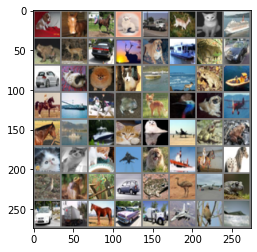

  dog horse horse   cat truck  deer   cat  ship


In [32]:


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(shadow_train_loader)
# images, labels, idx = dataiter.next()
# print("Labels: ", labels)

# # show images
# imshow(torchvision.utils.make_grid(images))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(shadow_train_loader)
images, labels, idx = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


In [69]:
""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (5,5), padding=2)
        self.conv2 = nn.Conv2d(32, 32, (5,5))
        self.fc1   = nn.Linear(32*6*6, 128)
        self.fc2   = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        # print(size)
        num_features = 1
        for s in size:
            num_features *= s
        # print(num_features)
        return num_features

from torchsummary import summary
net = LeNet().to(device)
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 32, 12, 12]          25,632
            Linear-3                  [-1, 128]         147,584
            Linear-4                   [-1, 10]           1,290
Total params: 176,938
Trainable params: 176,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 0.67
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [43]:
from torchsummary import summary
net = LeNet().to(device)
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 32, 12, 12]          25,632
Total params: 28,064
Trainable params: 28,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 0.11
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [ ]:
a_net = Feedforward(3,64).to(device)
print(a_net)

Feedforward(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [50]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20, attack=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in train_loader:
                    if attack:
                      inputs, labels = data
                    else:
                      inputs, labels, idx = data

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
                        # print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    
                scheduler.step()
                print(running_corrects)
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
            else:
                
                model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in test_loader:
                    if attack:
                      inputs, labels = data
                    else:
                      inputs, labels, idx = data
                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [51]:
def test(model, test_loader, criterion, optimizer, scheduler):
  model.eval()   # Set model to evaluate mode
                
  running_loss = 0.0
  running_corrects = 0
  # prediction_list = []
  i = 0
  for data in test_loader:
      inputs, labels, idx = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          sm = torch.nn.Softmax()
          pred_probs = sm(outputs)
          pred_probs, indices = torch.sort(pred_probs, descending=True)
          # print(pred_probs)
          if i == 0:
            prediction_list = pred_probs[:,0:3]
          else:
            prediction_list = torch.cat((prediction_list, pred_probs[:,0:3]))
          i += 1
          loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / test_size
  epoch_acc = running_corrects.double() / test_size

  print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
  
  return prediction_list

In [79]:
train_size = len(dataset.shadow_train)
test_size = len(dataset.shadow_test)
print(train_size, test_size)
net = LeNet().to(device)
# loading pretrained model
#     net = torch.load('LeNet_5_class_pretrained_model.tar')
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-07)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

best_net, best_acc = train_model(net, shadow_train_loader, shadow_test_loader, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=20)

12500 12500
Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(4169)
Train Loss: 2.1330 Acc: 0.3335
Val Loss: 2.0870 Acc: 0.3667

Epoch 1/19
----------
tensor(5345)
Train Loss: 2.0368 Acc: 0.4276
Val Loss: 2.0208 Acc: 0.4466

Epoch 2/19
----------
tensor(5917)
Train Loss: 1.9900 Acc: 0.4734
Val Loss: 1.9804 Acc: 0.4838

Epoch 3/19
----------
tensor(6447)
Train Loss: 1.9483 Acc: 0.5158
Val Loss: 1.9683 Acc: 0.4947

Epoch 4/19
----------
tensor(6914)
Train Loss: 1.9158 Acc: 0.5531
Val Loss: 1.9456 Acc: 0.5169

Epoch 5/19
----------
tensor(7360)
Train Loss: 1.8828 Acc: 0.5888
Val Loss: 1.9202 Acc: 0.5422

Epoch 6/19
----------
tensor(7715)
Train Loss: 1.8538 Acc: 0.6172
Val Loss: 1.9018 Acc: 0.5610

Epoch 7/19
----------
tensor(8144)
Train Loss: 1.8202 Acc: 0.6515
Val Loss: 1.8964 Acc: 0.5671

Epoch 8/19
----------
tensor(8521)
Train Loss: 1.7937 Acc: 0.6817
Val Loss: 1.8923 Acc: 0.5685

Epoch 9/19
----------
tensor(8890)
Train Loss: 1.7662 Acc: 0.7112
Val Loss: 1.8749 Acc: 0.5870

Epoch 10/19
----------
tensor(9158)
Train Loss: 1.7435 Acc: 0.

In [80]:
shadow_test_prediction = test(best_net, shadow_test_loader, criterion, optimizer_ft, exp_lr_scheduler)
shadow_train_prediction = test(best_net, shadow_train_loader, criterion, optimizer_ft, exp_lr_scheduler)

d1 = torch.utils.data.TensorDataset(shadow_train_prediction, torch.ones(train_size, dtype=torch.long))
d2 = torch.utils.data.TensorDataset(shadow_test_prediction, torch.zeros(test_size, dtype=torch.long))
shadow_trained_dataset = torch.utils.data.ConcatDataset([d1, d2])
len(shadow_trained_dataset)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 1.8599 Acc: 0.6032
Val Loss: 1.6014 Acc: 0.8666


25000

In [72]:
shadow_trained_dataset[0][0]

tensor([0.2204, 0.0891, 0.0878])

In [83]:
target_train_loader = DataLoader(dataset.target_train, batch_size=200, shuffle=True, num_workers=0)
target_unk_loader = DataLoader(dataset.target_unknown, batch_size=200, shuffle=True, num_workers=0)

train_size = len(dataset.target_train)
test_size = len(dataset.target_unknown)
target_net = LeNet().to(device)
# loading pretrained model
#     net = torch.load('LeNet_5_class_pretrained_model.tar')
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(target_net.parameters(), lr=0.001, weight_decay=1e-07)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

target_best_net, target_best_acc = train_model(target_net, target_train_loader, target_unk_loader, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(3411)
Train Loss: 2.1802 Acc: 0.2729
Val Loss: 2.1137 Acc: 0.3503

Epoch 1/19
----------
tensor(4907)
Train Loss: 2.0752 Acc: 0.3926
Val Loss: 2.0470 Acc: 0.4230

Epoch 2/19
----------
tensor(5640)
Train Loss: 2.0191 Acc: 0.4512
Val Loss: 2.0212 Acc: 0.4513

Epoch 3/19
----------
tensor(6134)
Train Loss: 1.9824 Acc: 0.4907
Val Loss: 1.9912 Acc: 0.4734

Epoch 4/19
----------
tensor(6530)
Train Loss: 1.9510 Acc: 0.5224
Val Loss: 1.9745 Acc: 0.4947

Epoch 5/19
----------
tensor(6889)
Train Loss: 1.9226 Acc: 0.5511
Val Loss: 1.9614 Acc: 0.5057

Epoch 6/19
----------
tensor(7241)
Train Loss: 1.8981 Acc: 0.5793
Val Loss: 1.9310 Acc: 0.5362

Epoch 7/19
----------
tensor(7556)
Train Loss: 1.8749 Acc: 0.6045
Val Loss: 1.9273 Acc: 0.5378

Epoch 8/19
----------
tensor(7814)
Train Loss: 1.8527 Acc: 0.6251
Val Loss: 1.9120 Acc: 0.5562

Epoch 9/19
----------
tensor(8124)
Train Loss: 1.8308 Acc: 0.6499
Val Loss: 1.8999 Acc: 0.5663

Epoch 10/19
----------
tensor(8362)
Train Loss: 1.8100 Acc: 0.

In [84]:
target_test_prediction = test(target_best_net, target_unk_loader, criterion, optimizer_ft, exp_lr_scheduler)
target_train_prediction = test(target_best_net, target_train_loader, criterion, optimizer_ft, exp_lr_scheduler)

d1 = torch.utils.data.TensorDataset(target_train_prediction, torch.ones(train_size, dtype=torch.long))
d2 = torch.utils.data.TensorDataset(target_test_prediction, torch.zeros(test_size, dtype=torch.long))
target_trained_dataset = torch.utils.data.ConcatDataset([d1, d2])
len(target_trained_dataset)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 1.8696 Acc: 0.5958
Val Loss: 1.6721 Acc: 0.8064


25000

In [85]:
class AttackModel(nn.Module):

  def __init__(self):
    super(AttackModel, self).__init__()

    self.fc1 = nn.Linear(3, 64)
    self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
      x = self.fc1(x)
      x = self.fc2(x)
      return x

class Feedforward(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
      super(Feedforward, self).__init__()
      self.input_size = input_size
      self.hidden_size  = hidden_size

      self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
      self.fc2 = torch.nn.Linear(self.hidden_size, 2)
      # self.sigmoid = torch.nn.Softmax()

  def forward(self, x):
      x = self.fc1(x)
      x = F.softmax(self.fc2(x))
      output = x
      
      return output

In [86]:
train_size = len(shadow_trained_dataset)
test_size = len(target_trained_dataset)
attack_model = Feedforward(3, 64).to(device)
atk_train_loader = DataLoader(shadow_trained_dataset, batch_size=10, shuffle=True, num_workers=0)
atk_test_loader = DataLoader(target_trained_dataset, batch_size=10, shuffle=True, num_workers=0)
optimizer_ft = optim.Adam(attack_model.parameters(), lr=0.01, weight_decay=1e-6)
from torchsummary import summary
# summary(attack_model, [1*3])
attack_best_net, attack_best_acc = train_model(attack_model, atk_train_loader, atk_test_loader, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40, attack=True)

Epoch 0/39
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(14708)
Train Loss: 0.6654 Acc: 0.5883
Val Loss: 0.6727 Acc: 0.6018

Epoch 1/39
----------
tensor(15412)
Train Loss: 0.6538 Acc: 0.6165
Val Loss: 0.6765 Acc: 0.6010

Epoch 2/39
----------
tensor(15528)
Train Loss: 0.6515 Acc: 0.6211
Val Loss: 0.6723 Acc: 0.5877

Epoch 3/39
----------
tensor(15622)
Train Loss: 0.6505 Acc: 0.6249
Val Loss: 0.6697 Acc: 0.5975

Epoch 4/39
----------
tensor(15470)
Train Loss: 0.6517 Acc: 0.6188
Val Loss: 0.6682 Acc: 0.6012

Epoch 5/39
----------
tensor(15615)
Train Loss: 0.6494 Acc: 0.6246
Val Loss: 0.6742 Acc: 0.6036

Epoch 6/39
----------
tensor(15672)
Train Loss: 0.6501 Acc: 0.6269
Val Loss: 0.6692 Acc: 0.6022

Epoch 7/39
----------
tensor(15618)
Train Loss: 0.6491 Acc: 0.6247
Val Loss: 0.6827 Acc: 0.5600

Epoch 8/39
----------
tensor(15732)
Train Loss: 0.6487 Acc: 0.6293
Val Loss: 0.6689 Acc: 0.5993

Epoch 9/39
----------
tensor(15678)
Train Loss: 0.6486 Acc: 0.6271
Val Loss: 0.6717 Acc: 0.6042

Epoch 10/39
----------
tensor(15602)
Train Loss: 0.6

In [89]:
def attack_test(model, test_loader, criterion, optimizer, scheduler):
  model.eval()   # Set model to evaluate mode
                
  running_loss = 0.0
  running_corrects = 0
  # prediction_list = []
  i = 0
  test_true_label = []
  test_pred_label = []
  for data in test_loader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          sm = torch.nn.Softmax()
          pred_probs = sm(outputs)
          pred_probs, indices = torch.sort(pred_probs, descending=True)
          # # print(pred_probs)
          # if i == 0:
          #   prediction_list = pred_probs[:,0:3]
          # else:
          #   prediction_list = torch.cat((prediction_list, pred_probs[:,0:3]))
          # i += 1
          loss = criterion(outputs, labels)

          test_true_label.append(labels.data)
          test_pred_label.append(preds.data)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / test_size
  epoch_acc = running_corrects.double() / test_size

  print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
  
  return test_true_label, test_pred_label


In [90]:
t_l, t_p = attack_test(attack_best_net, atk_test_loader, criterion, optimizer_ft, exp_lr_scheduler)
print(t_p)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val Loss: 0.6717 Acc: 0.6042
[tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1]), tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 1]), tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1]), tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 1]), tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 1]), tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0]), tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 0]), tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1]), tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1]), tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0]), tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 0]), tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1]), tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0]), tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1]), tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1]), tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 0]), tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 1]), tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1]), tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0]), tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0]), tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1]), tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0]), tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1]), tensor([1,

In [91]:
l_true = []
l_pred = []
for d in t_l:
    l_list = d.cpu().numpy()
    for l in l_list:
        l_true.append(l)
print(l_true)
for d in t_p:
    l_list = d.cpu().numpy()
    for l in l_list:
        l_pred.append(l)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 

In [92]:
from sklearn.metrics import classification_report

target_names = ['0','1']
print(classification_report(l_true, l_pred))

              precision    recall  f1-score   support

           0       0.65      0.44      0.53     12500
           1       0.58      0.77      0.66     12500

    accuracy                           0.60     25000
   macro avg       0.62      0.60      0.59     25000
weighted avg       0.62      0.60      0.59     25000



In [97]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(l_true, l_pred, labels=[1, 0])
    
print("Confusion Matrix:")
print(cm1)

print('\nStatistical Report:')
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Acc: ', round(accuracy1, 2))

prec = cm1[0,0]/(cm1[0,0]+cm1[1,0])
print('Precision: ', round(prec,2) )

rec = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Recall: ', round(rec,2))

Confusion Matrix:
[[9577 2923]
 [6971 5529]]

Statistical Report:
Acc:  0.6
Precision:  0.58
Recall:  0.77
